# Time Series Forecasting Using Transformer Network
Training a transformer model to forecast time series sequence of Thermic Oil Heater Inlet Temperature  
Using 10 timesteps to forecast 1 forward timestep

# 1. Definition

### 1.1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

### 1.2. Load dataset and set global variables

In [2]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 64

# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("your device is: ", device)

# read facebook dataset
df = pd.read_csv("../data/final_df_002.csv")
df.head()

your device is:  cuda


,Date Time,Heater Heat Output,T.F Heater Outlet Flow Transmitter,T.F. Heater Serpentine Coil Outlet Temperature,Heater Outlet Flue Gas O2 Analyzer,T.F. Heater Outlet Flue Gas Temperature,Average T.F. Heater Outlet Temperature,Average T.F. Heater Serpentine Coil Inlet Temperature,Average Furnace Exit Temperature
0,2024-08-01 06:40:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
1,2024-08-01 06:50:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
2,2024-08-01 07:00:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
3,2024-08-01 07:10:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
4,2024-08-01 07:20:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25


In [3]:
df.columns

Index(['Date Time', 'Heater Heat Output', 'T.F Heater Outlet Flow Transmitter',
       'T.F. Heater Serpentine Coil Outlet Temperature',
       'Heater Outlet Flue Gas O2 Analyzer',
       'T.F. Heater Outlet Flue Gas Temperature',
       'Average T.F. Heater Outlet Temperature',
       'Average T.F. Heater Serpentine Coil Inlet Temperature',
       'Average Furnace Exit Temperature'],
      dtype='object')

### 1.3. Preprocessing

In [4]:
# logarithmic normalization
# open = df["Average T.F. Heater Serpentine Coil Inlet Temperature"]
# open = np.array(open)
# open_logreturn = np.diff(np.log(open))
# open_csum_logreturn = open_logreturn.cumsum()


close = df["Average T.F. Heater Serpentine Coil Inlet Temperature"]
close = np.array(close)
close_logreturn = np.diff(np.log(close))
close_csum_logreturn = close_logreturn.cumsum()


# average = df["Average T.F. Heater Outlet Temperature"].fillna(method="ffill")
# average = np.array(average)
# average_logreturn = np.diff(np.log(average))
# average_csum_logreturn = average_logreturn.cumsum()

### 1.4. Plot input dataframes

Text(0, 0.5, 'Close Price')

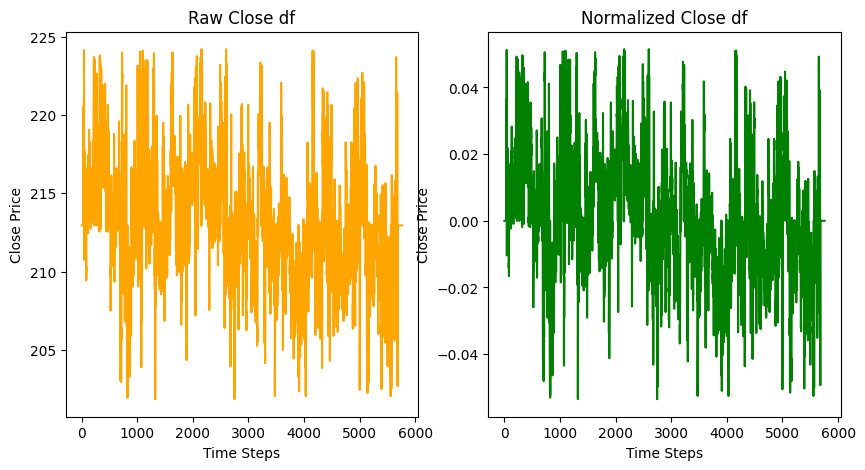

In [8]:
fig = plt.figure(figsize=(10, 5))

# plt.subplot(3, 2, 1)
# plt.plot(open, color="blue")
# plt.title("Raw Open df")
# plt.xlabel("Time Steps")
# plt.ylabel("Open Price")

# plt.subplot(3, 2, 2)
# plt.plot(open_csum_logreturn, color="red")
# plt.title("Normalized Open df")
# plt.xlabel("Time Steps")
# plt.ylabel("Open Price")

plt.subplot(1, 2, 1)
plt.plot(close, color="orange")
plt.title("Raw Close df")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")

plt.subplot(1, 2, 2)
plt.plot(close_csum_logreturn, color="green")
plt.title("Normalized Close df")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")

# plt.subplot(3, 2, 5)
# plt.plot(average, color="magenta")
# plt.title("Raw average df")
# plt.xlabel("Time Steps")
# plt.ylabel("average Price")

# plt.subplot(3, 2, 6)
# plt.plot(average_csum_logreturn, color="black")
# plt.title("Normalized average df")
# plt.xlabel("Time Steps")
# plt.ylabel("average Price")

Plot shows the reduced scale of the closing prices

# 2. Model Definition

### 2.1. Positional Encoding Layer

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

### 2.2. Transformer Model

In [10]:
class transformer(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(transformer, self).__init__()
        self.model_type = "Transformer"

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if(self.src_mask is None or self.src_mask.size(0) != len(src)):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

# 3. Utils Functions




### 3.1. Create Window Sequence

In [11]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

### 3.2. Split Data
Split data into the train and testing set, prepared in windowed sequences and pass through GPU

In [12]:
def get_data(data, split):

    series = data

    split = round(split * len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()

    # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
    # Similar to image transformation to allow model to train on wider data sets
    train_data = 2 * train_data

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

### 3.3. Split into training batches

In [13]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

### 3.4. Training Function

In [15]:
def train(train_data):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if(batch % log_interval == 0 and batch > 0):
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print("| epoch {:3d} | {:5d}/{:5d} batches | "
                  "lr {:02.10f} | {:5.2f} ms | "
                  "loss {:5.7f}".format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

### 3.5. Evaluation Function

In [16]:
def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.0
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

### 3.6. Forecast Function

#### 3.6.1. for one time step from window sequence

In [17]:
def model_forecast(model, seqence):
    model.eval()
    total_loss = 0.0
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode="constant", constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

#### 3.6.2. for entire sequence

In [18]:
def forecast_seq(model, sequences):

    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

# 4. Train Phase

### 4.1. Prepare data for train model

In [19]:
train_data, val_data = get_data(close_logreturn, 0.8) # 60% train, 40% test split
model = transformer().to(device)

/tmp/ipykernel_4075339/219410700.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(inout_seq)
/ml_data/env/ts/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### 4.2. Set Model Parameters

In [20]:
criterion = nn.MSELoss()
lr = 0.0005
epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

### 4.3. Training Loop

In [21]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print("-" * 80)
        print("| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}".format(epoch, (time.time() - epoch_start_time), val_loss))
        print("-" * 80)

    else:
        print("-" * 80)
        print("| end of epoch {:3d} | time: {:5.2f}s".format(epoch, (time.time() - epoch_start_time)))
        print("-" * 80)

    scheduler.step()


/ml_data/env/ts/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


| epoch   1 |    14/   71 batches | lr 0.0005000000 | 24.26 ms | loss 4.0382466
| epoch   1 |    28/   71 batches | lr 0.0005000000 |  5.07 ms | loss 0.0566305
| epoch   1 |    42/   71 batches | lr 0.0005000000 |  5.05 ms | loss 0.0161645
| epoch   1 |    56/   71 batches | lr 0.0005000000 |  5.03 ms | loss 0.0099090
| epoch   1 |    70/   71 batches | lr 0.0005000000 |  5.01 ms | loss 0.0108593
--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.63s
--------------------------------------------------------------------------------
| epoch   2 |    14/   71 batches | lr 0.0004512500 |  5.33 ms | loss 0.0077700
| epoch   2 |    28/   71 batches | lr 0.0004512500 |  5.00 ms | loss 0.0210126
| epoch   2 |    42/   71 batches | lr 0.0004512500 |  5.00 ms | loss 0.0043816
| epoch   2 |    56/   71 batches | lr 0.0004512500 |  5.00 ms | loss 0.0034557
| epoch   2 |    70/   71 batches | lr 0.0004512500 |  5.07 ms | loss 0.0045332
----

In [22]:
test_result, truth = forecast_seq(model, val_data)

1.7811965942382812 sec


# 5. Results

### 5.1. Plot forecasted sequence vs actual

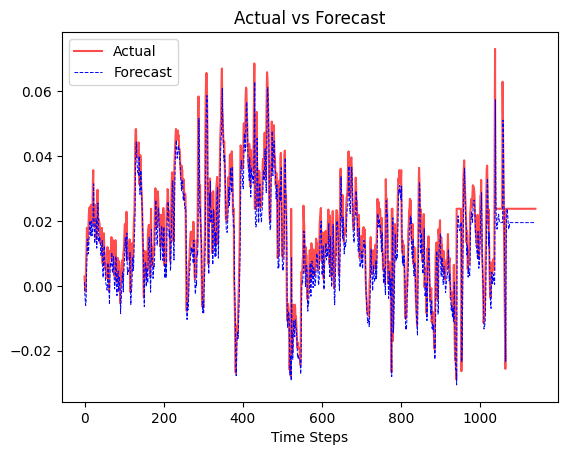

In [23]:
plt.plot(truth, color="red", alpha=0.7)
plt.plot(test_result, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

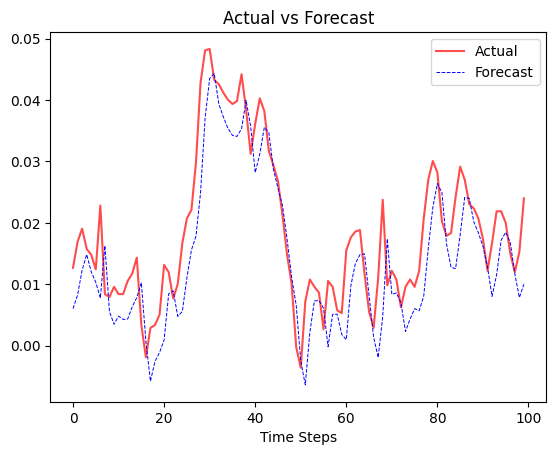

In [24]:
###Superimpose the forecasted sequence on the actual sequence
plt.plot(truth[100:200], color="red", alpha=0.7)
plt.plot(test_result[100:200], color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

# 6. Save Model

In [25]:
torch.save(model.state_dict(), "../model/transformer_model.pth")

# 7. Validation Phase

### 7.1. Load Model

In [ ]:
model_val = transformer()
model_val.load_state_dict(torch.load("../model/transformer_model.pth"))
model_val.to(device)

Testing model on Boeing stock from the same time period

### 7.2. Average T.F. Heater Outlet Temperature

In [27]:
# df2 = pd.read_csv("../data/boeing.csv")
close2 = df["Average T.F. Heater Outlet Temperature"]
close2 = np.array(close2)
logreturn2 = np.diff(np.log(close2))

# average = df["Average T.F. Heater Outlet Temperature"].fillna(method="ffill")
# average = np.array(average)
# average_logreturn = np.diff(np.log(average))

In [28]:
train_data2, val_data2 = get_data(logreturn2, 0.8)
test2_eval = evaluate(model_val, val_data2)
print(f"boeing test loss: {test2_eval :.5f}")

boeing test loss: 0.00008


1.783341407775879 sec


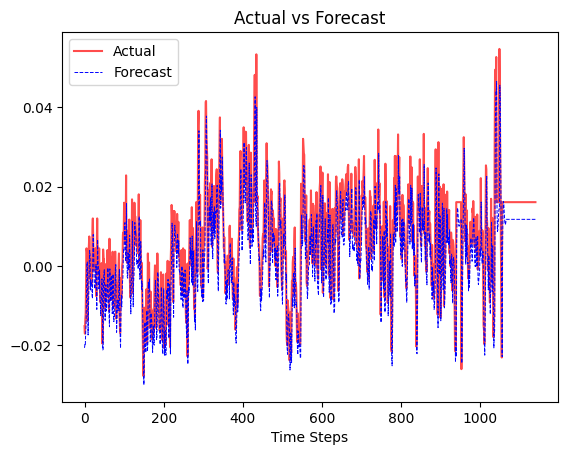

In [29]:
test_result2, truth2 = forecast_seq(model_val, val_data2)

plt.plot(truth2, color="red", alpha=0.7)
plt.plot(test_result2, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

### 7.3. T.F. Heater Serpentine Coil Outlet Temperature

In [30]:
# df3 = pd.read_csv("../data/jp_morgan.csv")
close3 = df["T.F. Heater Serpentine Coil Outlet Temperature"]
close3 = np.array(close3)
logreturn3 = np.diff(np.log(close3))

In [31]:
train_data3, val_data3 = get_data(logreturn3, 0.6)
test3_eval = evaluate(model_val, val_data3)
print(f'T.F. Heater Serpentine Coil Outlet Temperature test loss: {test3_eval :.5f}')

T.F. Heater Serpentine Coil Outlet Temperature test loss: 0.00007


3.532802104949951 sec


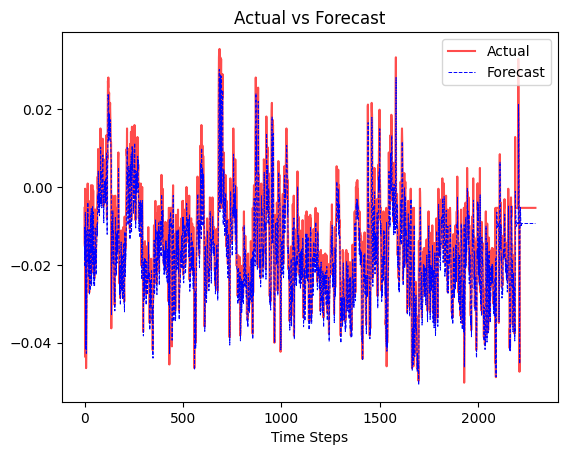

In [32]:
test_result3, truth3 = forecast_seq(model_val, val_data3)

plt.plot(truth3, color="red", alpha=0.7)
plt.plot(test_result3, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

3.565777063369751 sec


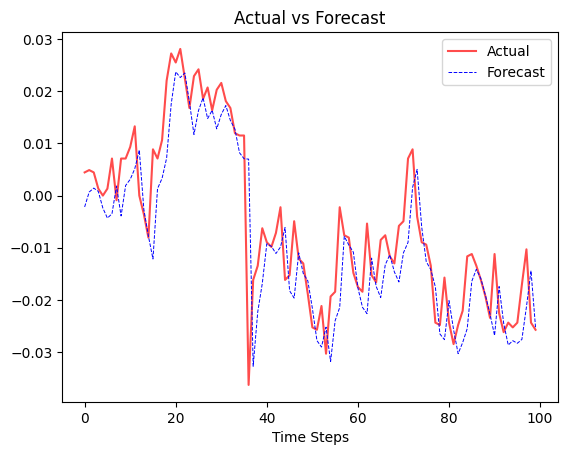

In [33]:
test_result3, truth3 = forecast_seq(model_val, val_data3)

plt.plot(truth3[100:200], color="red", alpha=0.7)
plt.plot(test_result3[100:200], color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()